#  CNN ile Gameplay Images Sınıflandırılması 

Veri Kümesi, Youtube'daki ünlü oyun videolarından birkaç saniyede bir kareler kaydedilerek oluşturulmuştur. Bu, dünyadaki en ünlü 10 video oyununun veri kümesidir.

Bunlar şunları içerir:

- Among Us
- Apex Legends
- Fortnite
- Forza Horizon
- Free Fire
- Genshin Impact
- God of War
- Minecraft
- Roblox
- Terraria

Sınıf başına 1000 adet, toplam 10000 adet görsel bulunmaktadır. Bu görsellerin tamamı 640 x 360 boyutundadır. Bunlar .png formatındadır.

CNN (Convolutional Neural Network), evrişimli sinir ağı anlamına gelir. CNN'ler, özellikle görsel veri analizi ve tanıma görevlerinde kullanılan derin öğrenme modelleridir. Bu ağlar, veri içindeki özellikleri hiyerarşik olarak öğrenme yeteneğine sahiptir ve bu nedenle özellikle bilgisayarlı görü ve görüntü sınıflandırma alanlarında yaygın olarak kullanılır.

# İlk olarak gerekli kütüphanelerin yüklemelerini yapıyorum

In [1]:
pip install split_folders

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings #Python uyarı mesajlarını kontrol etmek için bir modülü içe aktarır.
warnings.filterwarnings('ignore') #Uyarı mesajlarını görmezden gelmek için bir filtre uygular.
import splitfolders #Veri setini eğitim, doğrulama ve test kümelerine ayırmak için bir modülü içe aktarır.
import itertools #İterasyon ve kombinasyon işlemleri için bir modülü içe aktarır.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D #Keras'tan yoğun katman, bırakma (dropout), düzleştirme (flatten), 
# konvolüsyonel (Conv2D) ve maksimum havuzlama (MaxPool2D) katmanlarını içe aktarır.
import time
import random
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Buradaki kod, kodun başlangıç zamanını tutmaktadır.

In [3]:
baslangic_zamani = time.time()

# Datasetimizi 'Data' değişkenine tanımlıyoruz.

In [4]:
Data ="/kaggle/input/gameplay-images/Dataset"

# Burada datasetimiz train validation test olarak ayırıyor. Bu ayrımı sırasıyla Train %70, Validation %20 ve Test %10 olarak yapmaktadır

In [5]:
splitfolders.ratio(Data, output='Gameplay_Image_Train_Validation_Test', seed=42, ratio=(.7, .2, .1), group_prefix=None)

Copying files: 10000 files [01:58, 84.25 files/s]


# Burada her eğitim iterasyonunda kullanılacak olan örnek sayısını belirtilmekte ve resimlerin boyutu 224*224 piksele çevrilmektedir.

In [6]:
BATCH_SIZE = 20

IMAGE_SIZE = (224, 224)

# Burada ayırmış olduğumuz verilerin tanımlamaları yapılmaktadır.

In [7]:
Train = keras.utils.image_dataset_from_directory(
    
    directory = 'Gameplay_Image_Train_Validation_Test/train', #Eğitim veri kümesinin bulunduğu dizini belirtmektedir.
    labels = 'inferred', #Sınıf etiketlerini otomatik olarak çıkarmak için kullanılmaktadır.
    label_mode = 'int', #Sınıf etiketlerini tam sayı olarak temsil etmek için kullanılmaktadır.
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Validation = keras.utils.image_dataset_from_directory(
    directory = 'Gameplay_Image_Train_Validation_Test/val',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Test = keras.utils.image_dataset_from_directory(
    directory = 'Gameplay_Image_Train_Validation_Test/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    seed = 42,
)

Found 7000 files belonging to 10 classes.
Found 2000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


# Burada, eğitim (Train), doğrulama (Validation), ve test (Test) veri kümelerinde bulunan sınıf isimlerini elde etmek için bir döngü oluşturduk.

In [8]:
for i in [Train, Validation, Test]:
    class_names = i.class_names
    print(class_names)

['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']
['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']
['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']


# Burada, eğitim (Train), doğrulama (Validation) ve test (Test) veri kümelerinde bulunan sınıf sayılarını ve sınıf isimlerini yazdırılmaktadır.

In [9]:
print(f"Eğitim kümesinde {len(Train.class_names)} sınıf bulunmaktadır. Bunlar: {Train.class_names}")
print(f"\n")
print(f"Doğrulama kümesinde {len(Validation.class_names)} sınıf bulunmaktadır. Bunlar: {Validation.class_names}")
print(f"\n")
print(f"Test kümesinde {len(Test.class_names)} sınıf bulunmaktadır. Bunlar: {Test.class_names}")

Eğitim kümesinde 10 sınıf bulunmaktadır. Bunlar: ['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']


Doğrulama kümesinde 10 sınıf bulunmaktadır. Bunlar: ['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']


Test kümesinde 10 sınıf bulunmaktadır. Bunlar: ['Among Us', 'Apex Legends', 'Fortnite', 'Forza Horizon', 'Free Fire', 'Genshin Impact', 'God of War', 'Minecraft', 'Roblox', 'Terraria']


# Burada, bir eğitim (train), doğrulama (validation) ve test veri seti üzerinde döngü kullanarak, her bir veri setinin ilk batch'inin şeklini ve toplam batch sayısını ekrana yazdırılmaktadır.

In [10]:
for image_batch, labels_batch in Train:
    print(f"Eğitim Şekli:: {image_batch.shape} (Toplam Batch Sayısı = {len(Train)})")
    print(f"\n")
    break
for image_batch, labels_batch in Validation:
    print(f"Doğrulama Şekli:: {image_batch.shape} (Toplam Batch Sayısı = {len(Validation)})")
    print(f"\n")
    break
for image_batch, labels_batch in Test:
    print(f"Test Şekli: {image_batch.shape} (Toplam Batch Sayısı = {len(Test)})")
    print(f"\n")
    break

Eğitim Şekli:: (20, 224, 224, 3) (Toplam Batch Sayısı = 350)


Doğrulama Şekli:: (20, 224, 224, 3) (Toplam Batch Sayısı = 100)


Test Şekli: (20, 224, 224, 3) (Toplam Batch Sayısı = 50)




# Train, Validation ve Test verilerinin görselleştirilmesi yapılmaktadır.

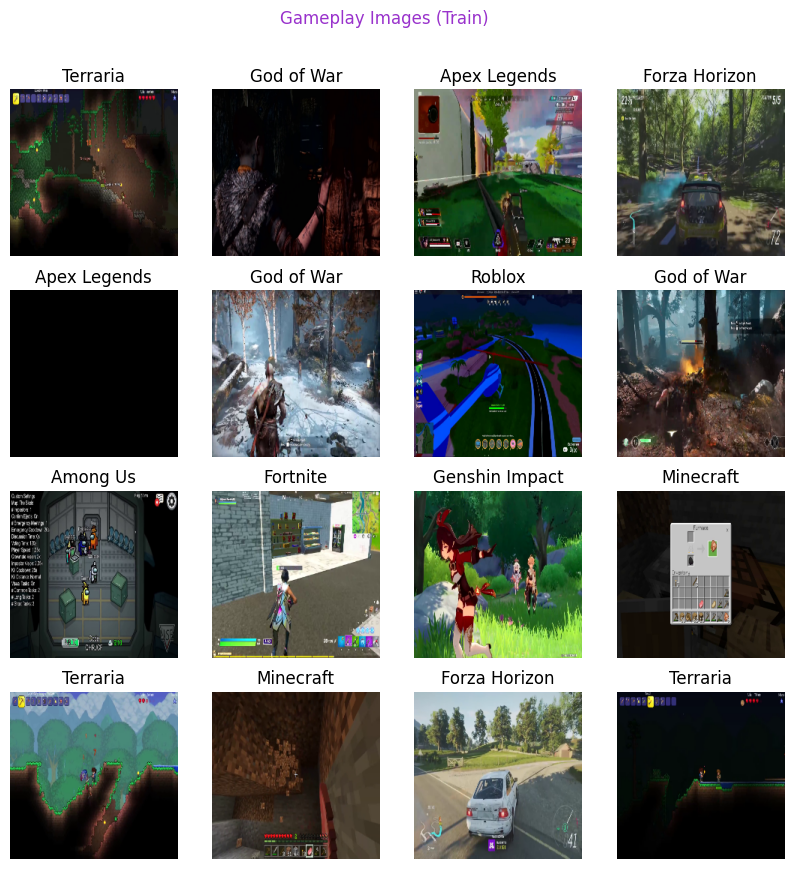

In [11]:
# Eğitim kümesini doğru formatta olduğunu kontrol etmek için görselleştir

plt.figure(figsize=(10, 10))
for images, labels in Train.take(1):
      for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.suptitle('Gameplay Images (Train)', y=0.96, color='darkorchid')
plt.show()


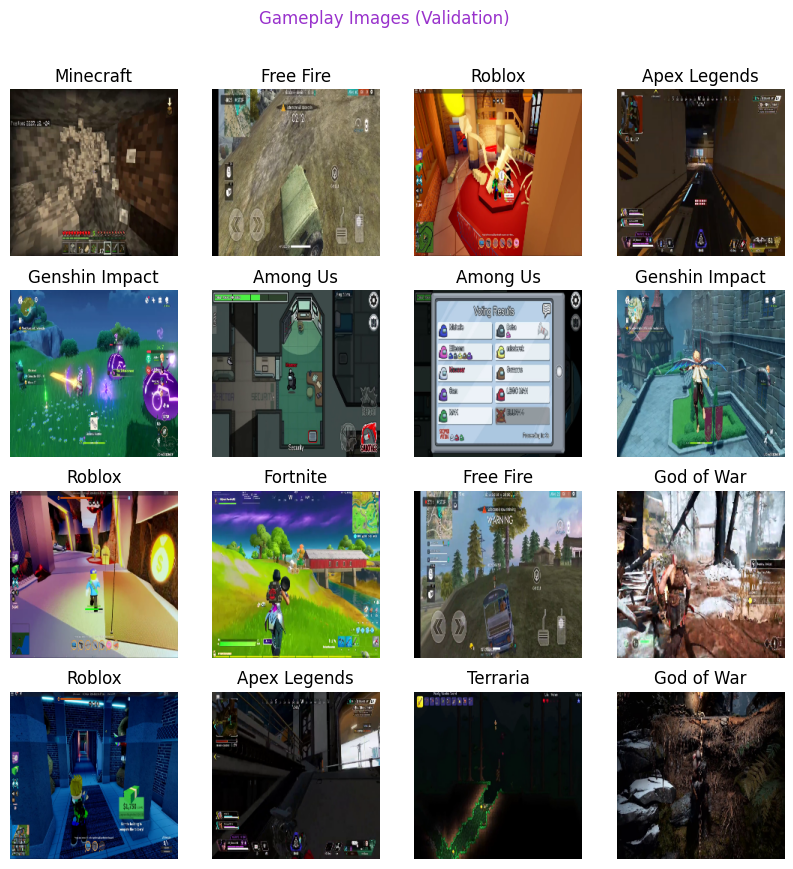

In [12]:
# Doğrulama kümesini doğru formatta olduğunu kontrol etmek için görselleştir

plt.figure(figsize=(10, 10))
for images, labels in Validation.take(1):
      for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.suptitle('Gameplay Images (Validation)', y=0.96, color='darkorchid')
plt.show()


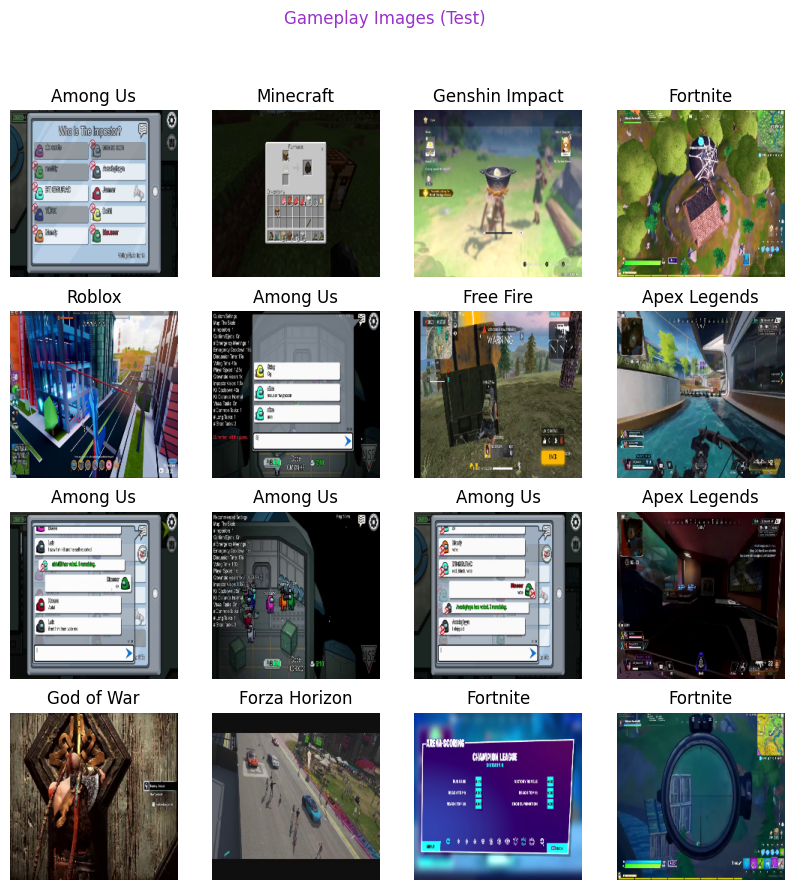

In [13]:
# Test kümesini doğru formatta olduğunu kontrol etmek için görselleştir

plt.figure(figsize=(10, 10))
for images, labels in Test.take(1):
      for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint16"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        plt.suptitle('Gameplay Images (Test)', y=0.98, color='darkorchid')
plt.show()

# CNN Modeli Katmanları Uygulanmaktadır.

Conv2D Katmanları:

- İlk Conv2D katmanı, 32 adet 3x3 boyutunda filtre kullanarak giriş görüntüsünden özellikler çıkarır. Aktivasyon fonksiyonu olarak 'relu' kullanılmıştır.
- İkinci Conv2D katmanı, 64 adet 3x3 boyutunda filtre kullanarak daha karmaşık özellikler çıkarmayı amaçlar. Yine 'relu' aktivasyon fonksiyonu kullanılmıştır.

MaxPooling2D Katmanları:

- Her Conv2D katmanının ardından MaxPooling2D katmanı eklenmiştir. Bu katmanlar, özellik haritalarını küçültmek ve öğrenilen özellikleri öne çıkarmak için girişten maksimum değerleri çıkaran bir havuzlama işlemi uygular.

Flatten Katmanı:

- Flatten katmanı, önceki katmanlardan gelen özellik haritalarını düzleştirerek bir vektör haline getirir. Bu, tam bağlantılı katmanlara giriş olarak veri sağlar.

Dense (Tam Bağlantılı) Katman:

- 128 nöron içeren bir tam bağlantılı katman eklenmiştir. 'relu' aktivasyon fonksiyonu kullanılmıştır. Bu katman, düzleştirilmiş özellik vektöründen karmaşık ilişkiler öğrenmeye çalışır.

Dropout Katmanı:

- Dropout, aşırı öğrenmeyi önlemek amacıyla eğitim sırasında rastgele seçilen nöronları devre dışı bırakarak ağı düzenler.

Çıkış Katmanı:

- 10 sınıflı çok sınıflı sınıflandırma problemi için kullanılan softmax aktivasyon fonksiyonu ile bir çıkış katmanı eklenmiştir.

Model Derleme:

- 'adam' optimizer kullanılarak model derlenmiştir.
- Kayıp fonksiyonu olarak 'sparse_categorical_crossentropy' kullanılmıştır.
- Doğruluk (accuracy) metriği kullanılarak modelin performansı değerlendirilir.

Eğitim:

- Model, eğitim verileri üzerinde belirtilen epoch sayısı (15) boyunca eğitilmiştir.

In [14]:
# Evrişimli Sinir Ağı (CNN) Oluşturma
CNN1 = Sequential()

# Evrişim İşlemi
CNN1.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu',input_shape=(224, 224, 3)))

# Batch Normalization ekleyin
CNN1.add(BatchNormalization())

# Havuzlama (Pooling)
CNN1.add(MaxPool2D(pool_size=(2, 2)))

# Evrişim İşlemi
CNN1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Batch Normalization ekleyin
CNN1.add(BatchNormalization())

# Havuzlama (Pooling)
CNN1.add(MaxPool2D(pool_size=(2, 2)))

# Düzleştirme
CNN1.add(Flatten())

#Dropout
CNN1.add(Dropout(0.25))

# Tam Bağlantılı Katman (Fully Connected Layer)
CNN1.add(Dense(units=128, activation='relu'))

#Dropout
CNN1.add(Dropout(0.5))

# Çıkış katmanı
CNN1.add(Dense(units=10, activation='softmax'))  # Çok sınıflı sınıflandırma için 'softmax'ı kullanın

# Modeli Derleme
CNN1.compile(optimizer=Adam(lr=0.001),#Öğrenme oranını azaltma
             loss='sparse_categorical_crossentropy',  # Kayıp fonksiyonunu değiştirin
             metrics=['accuracy'])

# CNN'i Eğitme (eğitim ve doğrulama verileri ile)
Model1 = CNN1.fit(x=Train, validation_data=Validation, epochs=10)


Epoch 1/10
350/350 [==============================] - 41s 72ms/step - loss: 4.7400 - accuracy: 0.8450 - val_loss: 3.5093 - val_accuracy: 0.8305
Epoch 2/10
350/350 [==============================] - 26s 73ms/step - loss: 0.9280 - accuracy: 0.9140 - val_loss: 1.3545 - val_accuracy: 0.9340
Epoch 3/10
350/350 [==============================] - 26s 74ms/step - loss: 0.6362 - accuracy: 0.9340 - val_loss: 0.3597 - val_accuracy: 0.9645
Epoch 4/10
350/350 [==============================] - 26s 72ms/step - loss: 0.6674 - accuracy: 0.9400 - val_loss: 0.3208 - val_accuracy: 0.9665
Epoch 5/10
350/350 [==============================] - 26s 72ms/step - loss: 0.4360 - accuracy: 0.9439 - val_loss: 0.4421 - val_accuracy: 0.9715
Epoch 6/10
350/350 [==============================] - 25s 70ms/step - loss: 0.3672 - accuracy: 0.9530 - val_loss: 0.1889 - val_accuracy: 0.9755
Epoch 7/10
350/350 [==============================] - 26s 73ms/step - loss: 0.2871 - accuracy: 0.9533 - val_loss: 0.1105 - val_accuracy:

# CNN modelinin özet gösterimi aşağıdaki gibidir.

In [15]:
# Özet
CNN1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                        

# Burada model çıktıları olan loss ve accuracy verilerinin ayrı ayrı grafiksel gösterimi mevcuttur.

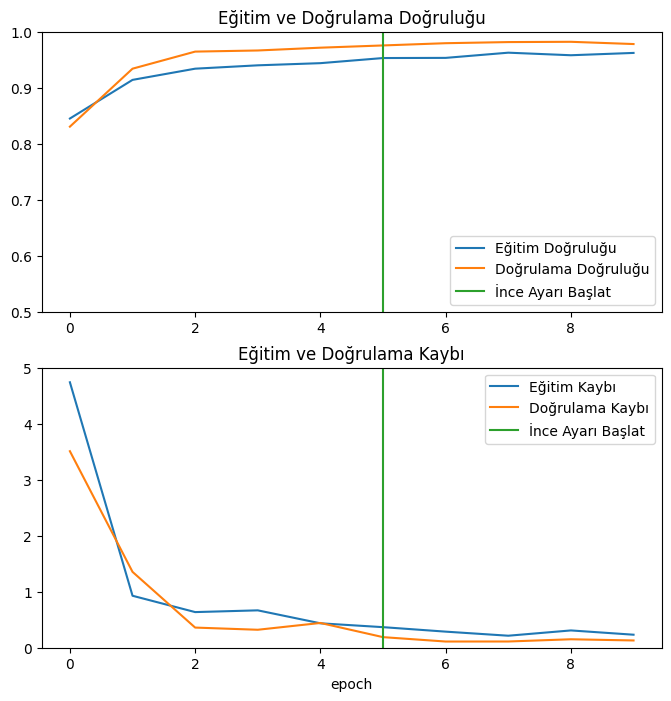

In [16]:
acc = Model1.history['accuracy']
val_acc = Model1.history['val_accuracy']
loss = Model1.history['loss']
val_loss = Model1.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Eğitim Doğruluğu')
plt.plot(val_acc, label='Doğrulama Doğruluğu') 
plt.ylim([0.5, 1])
plt.plot([5, 5], plt.ylim(), label='İnce Ayarı Başlat')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu') 

plt.subplot(2, 1, 2)
plt.plot(loss, label='Eğitim Kaybı')
plt.plot(val_loss, label='Doğrulama Kaybı')  
plt.ylim([0, 5])
plt.plot([5, 5], plt.ylim(), label='İnce Ayarı Başlat')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı') 

plt.xlabel('epoch')
plt.show()

# Karışıklık matrisi çizimi için bir fonksiyon oluşturulmaktadır.

In [17]:

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,7)) # Görselleştirme boyutu belirlenir
    plt.grid(False)  # Izgara kapatılır
    plt.imshow(cm, interpolation='nearest', cmap=cmap) # Karışıklık matrisi renkli bir şekilde gösterilir
    plt.title(title)
    plt.colorbar() # Renk çubuğu eklenir
    tick_marks = np.arange(len(classes))

    # Eksen işaretleri ayarlanır
    plt.xticks(tick_marks, [f"{value}={key}" for key , value in classes.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in classes.items()])

    # Hücrelerin içine değerler ve yüzdelikleri eklenir
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Eksen etiketleri eklenir
    plt.ylabel('Gerçek')
    plt.xlabel('Tahmin Edilen')
    plt.tight_layout() # Düzenleme yapılır
    plt.show() # Görselleştirme gösterilir

In [18]:
def get_true_pred_images(dataset, model):
    y_true = [] #Gerçek etiketleri tutacak liste
    y_pred = [] #Modelin tahmin ettiği etiketleri tutacak liste
    images_list = [] #İlgili görüntüleri tutacak liste

    for images, labels in dataset:
        labels = labels.numpy() # labels'ı numpy dizisine dönüştür
        
        # Model üzerinden softmax aktivasyonunu uygula ve tahmin et
        outputs = tf.nn.softmax(model(images))
        pred = tf.argmax(outputs, axis=1).numpy()
        
        images = images.numpy() # images'ı numpy dizisine dönüştür
        
        # Gerçek etiketleri ve tahmin edilen etiketleri listelere ekle
        y_true = np.append(y_true, labels)
        y_pred = np.append(y_pred, pred)
        
        images_list.extend(images) # İlgili görüntüleri images_list'e ekle

    return y_true, y_pred, images_list # Gerçek etiketleri, tahmin edilen etiketleri ve ilgili görüntüleri döndür

# Hata analizi için karışılık matrisi çizimi yapılmaktadır.

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97       100
         1.0       0.97      0.99      0.98       100
         2.0       1.00      0.98      0.99       100
         3.0       0.98      0.99      0.99       100
         4.0       1.00      0.97      0.98       100
         5.0       0.99      0.98      0.98       100
         6.0       0.92      0.95      0.94       100
         7.0       1.00      0.99      0.99       100
         8.0       1.00      0.99      0.99       100
         9.0       1.00      0.99      0.99       100

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000
 




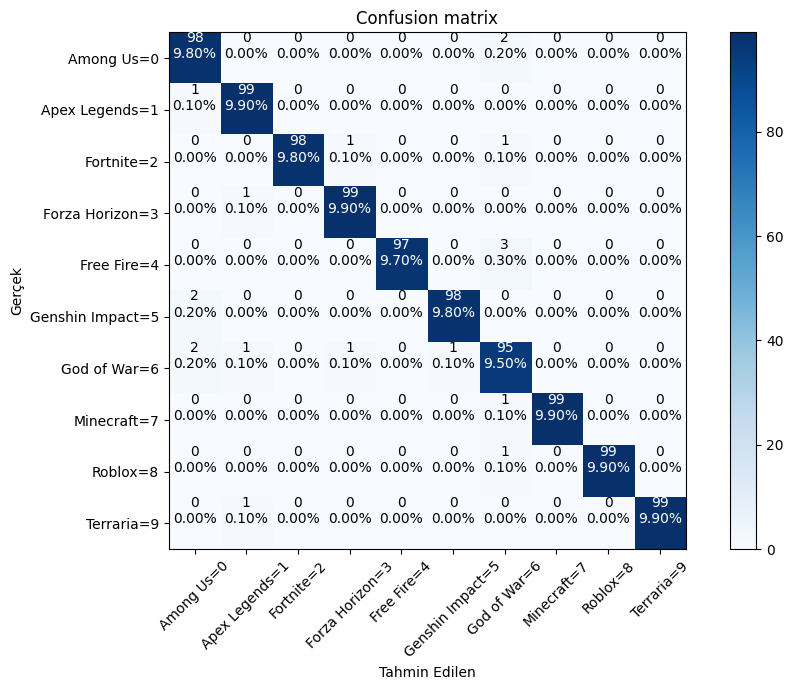

In [19]:
y_true_test, y_pred_test, test_images = get_true_pred_images(Test, CNN1)


print(classification_report(y_true_test, y_pred_test), '\n\n')
cm = confusion_matrix(y_true_test, y_pred_test)

classes = {

    0: "Among Us",
    1: "Apex Legends",
    2: "Fortnite",
    3: "Forza Horizon",
    4: "Free Fire",
    5: "Genshin Impact",
    6: "God of War",
    7: "Minecraft",
    8: "Roblox",
    9: "Terraria",

    
}

plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)



# Doğru tahmin edilen resimlerin gösterimi yapılmaktadır.

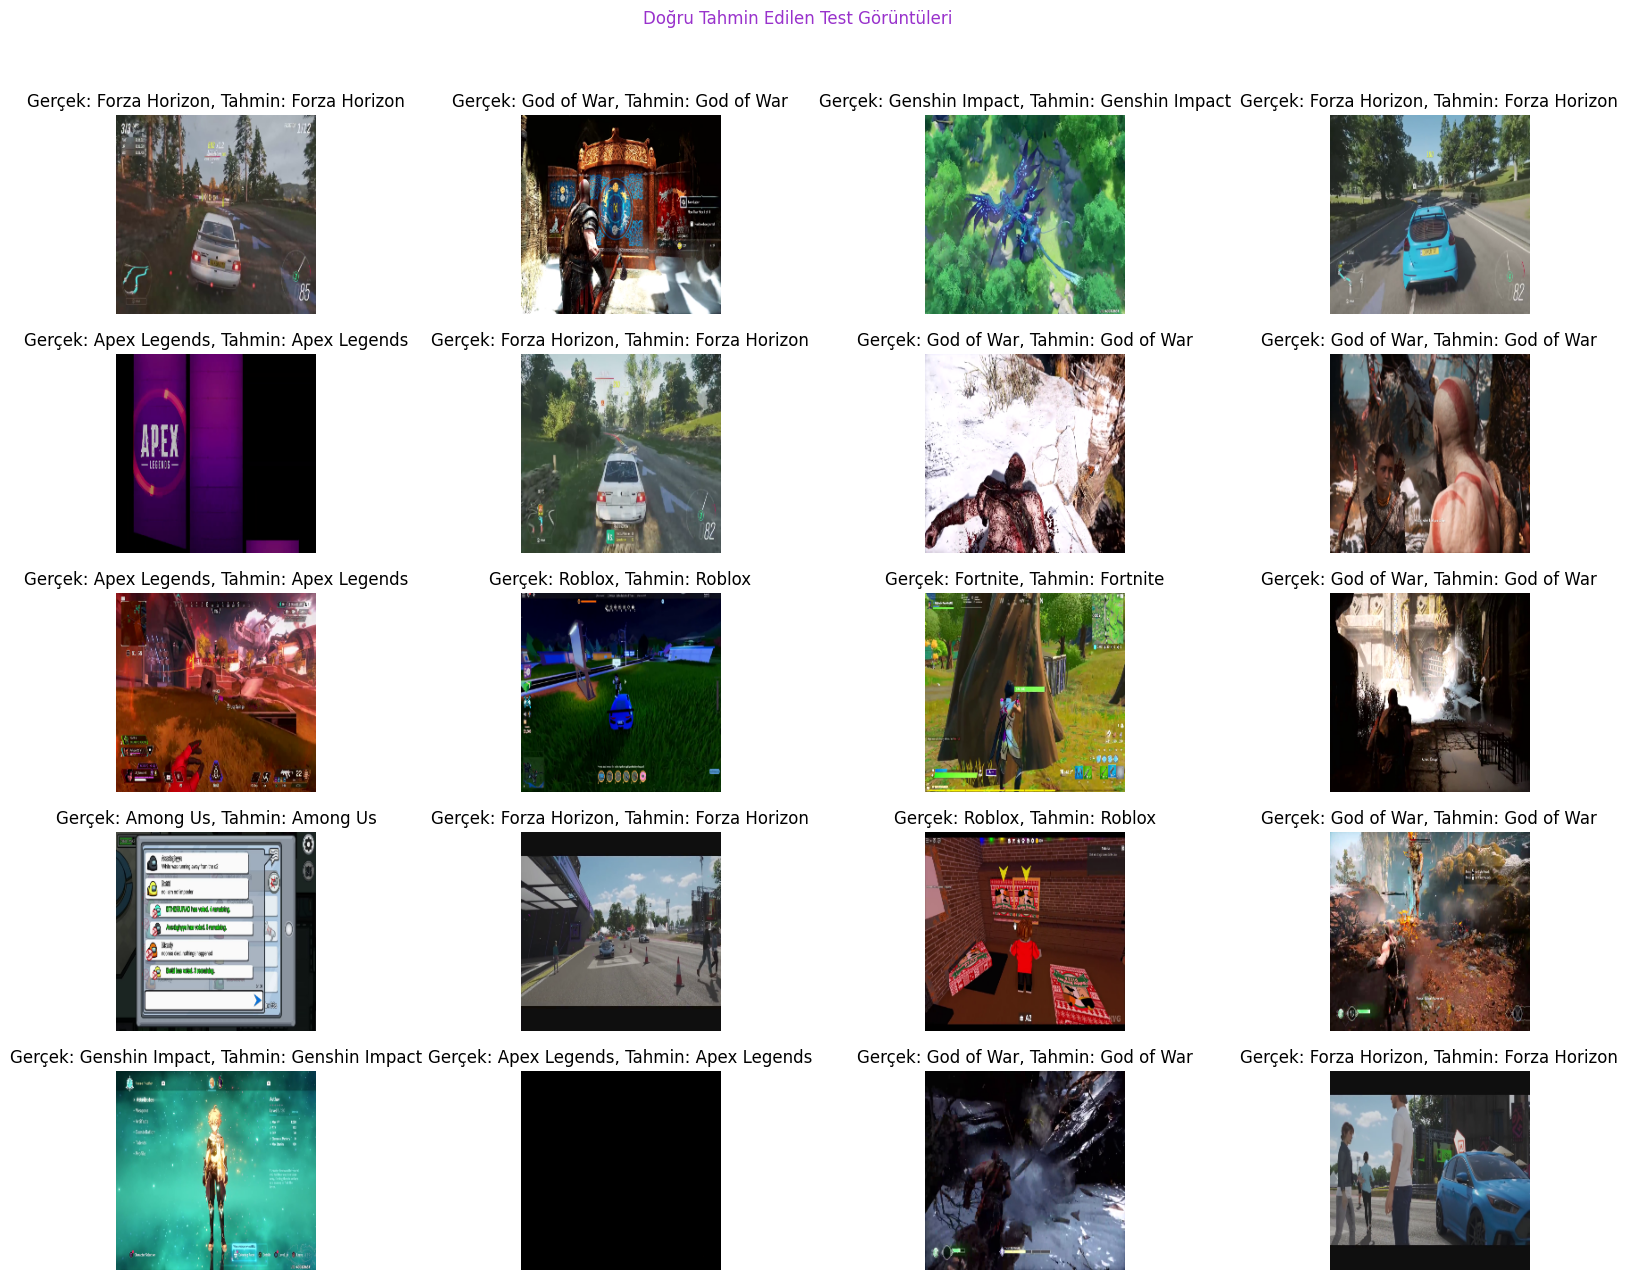

In [20]:
# Doğru tahmin edilen indisleri bulma
correctly_predicted_indices = np.where(y_true_test == y_pred_test)[0]

# Rastgele doğru tahmin edilen indisleri seçme
random_correct_indices = random.sample(list(correctly_predicted_indices), 20)

# Görüntülerin görselleştirilmesi
plt.figure(figsize=(20, 15))
for i, idx in enumerate(random_correct_indices):
    image = tf.cast(test_images[idx], tf.uint8)
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image)
    plt.title(f'Gerçek: {class_names[int(y_true_test[idx])]}, Tahmin: {class_names[int(y_pred_test[idx])]}')
    plt.axis("off")

plt.suptitle('Doğru Tahmin Edilen Test Görüntüleri', y=0.95, color='darkorchid')
plt.show()

# Son olarak ise kodun başlangıçtan bitişe kadar geçen süresi gösterilmektedir.

In [21]:
bitis_zamani = time.time()
egitim_suresi = bitis_zamani - baslangic_zamani

print(f"Eğitim süresi: {egitim_suresi} saniye")

Eğitim süresi: 427.75489139556885 saniye
